In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from dask.diagnostics import ProgressBar
import xskillscore as xs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [51]:
gcm = 'NorESM2-MM'
df_nobn = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty_nobn/{gcm}_Intensity_Penalty_nobn_hist_1986_2005_cascaded_perfect_applied.nc', chunks = {"time":5000}).sel(time = slice("2000", "2005"))
df_bn_ic = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty/{gcm}_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied.nc', chunks = {"time":5000}).sel(time = slice("2000", "2005"))
df_tanh = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Tanh_Activation/{gcm}_hist_1986_2005_cascaded_perfect_applied.nc', chunks = {"time":5000}).sel(time = slice("2000", "2005"))
df_leaky = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/LeakyRelu_Activation/{gcm}_LeakyRelu_Activation_hist_1986_2005_cascaded_perfect_applied.nc', chunks = {"time":5000}).sel(time = slice("2000", "2005"))

with ProgressBar():
    #df_nobn = df_nobn.sel(time = slice("2000", "2005")).load()
    df_bn_ic = df_bn_ic.sel(time = slice("2000", "2005")).load()
    df_leaky = df_leaky.sel(time = slice("2000", "2005")).load()

[########################################] | 100% Completed | 10.9s
[########################################] | 100% Completed | 11.5s


In [50]:
df_nobn = []
df_bn_ic = []
df_tanh = []
df_leaky = []
gcm = 'NorESM2-MM'

In [52]:
# df1 = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average_No_Ensemble_Mean/{gcm}_IC_AC_hist_1985_2014_10_perfect_framework_v3.nc',
#                       chunks = {"time":5000}).sel(time = slice("2000","2005"))
# df2 = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average/{gcm}_IC_AC_hist_2001_2014_10_perfect_framework_v2.nc',
#                       chunks = {"time":5000}).sel(time = slice("2000","2005"))
df3 = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Constrained/{gcm}_IC_hist_2001_2014_10_perfect_framework_v2.nc',
                     chunks = {"time":5000}).sel(time = slice("2000","2005"))
df4 = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/No_Constraint/{gcm}_hist_2001_2014_10_perfect_framework_v2.nc',
                     chunks = {"time":5000}).sel(time = slice("2000","2005"))


In [53]:
with ProgressBar():
    df4 = df4.load()
    #df1 = df1.load()
    #df2 = df2.load()
    df3 = df3.load()

[########################################] | 100% Completed | 28.4s
[########################################] | 100% Completed | 27.3s


In [54]:
ground_truth = xr.open_dataset(r"/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc").sel(GCM = gcm)
ground_truth['time'] = pd.to_datetime(ground_truth.time.dt.strftime("%Y-%m-%d"))
common_times = ground_truth.time.to_index().intersection(df3.time.to_index())
with ProgressBar():
    ground_truth = ground_truth.sel(time = common_times).load()

In [55]:
quantiles = (ground_truth.pr*86400).where(ground_truth.pr*86400>0.1, np.nan).quantile(q =0.95, dim ="time")

In [ ]:
def compute_crps(x, y):
    common_time = x.time.to_index().intersection(y.time.to_index())
    x = x.pr.sel(time = common_time)
    y = y.pr.sel(time = common_time)
    
    max_x = x.coarsen(lat =4, lon =4, boundary ='trim').max()
    max_y = y.coarsen(lat =4, lon =4, boundary ='trim').max()
    
    max_16x = x.coarsen(lat =16, lon =16, boundary ='trim').max()
    max_16y = y.coarsen(lat =16, lon =16, boundary ='trim').max()
    crps_pixel = xs.crps_ensemble(y*3600*24,x, dim ="time").to_dataset(name = "crps_pixel")
    crps_pixel_max = xs.crps_ensemble(max_y*3600*24,max_x, dim ="time").to_dataset(name = "crps_pixel4pooled")
    crps_pixel_max16 = xs.crps_ensemble(max_16y*3600*24,max_16x, dim ="time").to_dataset(name = "crps_pixel16pooled")
    merged = xr.merge([crps_pixel, crps_pixel_max, crps_pixel_max16])
    return merged

In [9]:
def compute_mae(x, y):
    common_time = x.time.to_index().intersection(y.time.to_index())
    x = x.pr.sel(time = common_time)
    y = y.pr.sel(time = common_time)
    crps_pixel = xs.mae(y*3600*24,x.mean("member"), dim ="time").to_dataset(name = "mae")
    return crps_pixel

In [10]:

with ProgressBar():
    crps_ = compute_mae(df1, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_Experiment5.nc')
    crps_2 = compute_mae(df2, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_experiment3.nc')
    crps_3 = compute_mae(df3, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_experiment1.nc')
    crps_4 = compute_mae(df4, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_experiment2.nc')

In [125]:
df1, df2, df3, df4 = [],[],[],[]

In [130]:
with ProgressBar():
    crps5 = compute_mae(df_nobn, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_Experiment8.nc')
    crps6= compute_mae(df_bn_ic, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_experiment6.nc')
    crps7 = compute_mae(df_leaky, ground_truth).to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/MAE_experiment7.nc')



In [121]:
crps_

<xarray.Dataset>
Dimensions:             (lon: 234, lat: 225, experiment: 7)
Coordinates:
  * lon                 (lon) float32 164.9 165.0 165.0 ... 183.7 183.9 184.0
  * lat                 (lat) float32 -51.21 -51.11 -51.05 ... -32.97 -32.86
  * experiment          (experiment) float64 0.0 0.0001 0.001 ... 0.005 0.01 0.1
Data variables:
    crps_pixel          (experiment, lat, lon) float64 ...
    crps_pixel4pooled   (experiment, lat, lon) float64 nan nan nan ... nan nan
    crps_pixel16pooled  (experiment, lat, lon) float64 nan nan nan ... nan nan

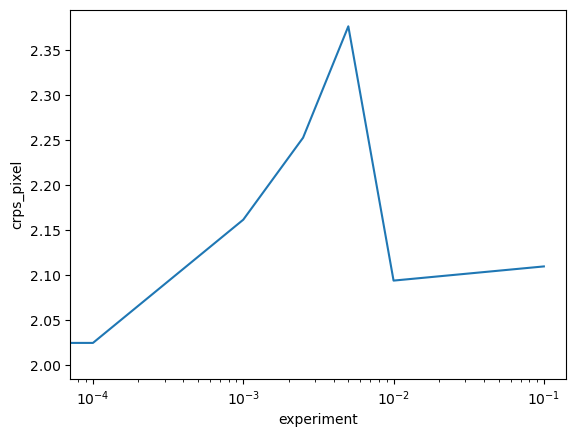

In [122]:
fig, ax = plt.subplots()
crps_.crps_pixel.mean(["lat","lon"]).plot(ax = ax)
ax.set_xscale('log')

In [31]:
z1 =  df1.pr.isel(member =0,experiment =2).sel(lat =-39, lon=176, method ='nearest').values

In [36]:
z = (df1.isel(time = slice(0,100)).pr < ground_truth.pr.isel(time = slice(0,100))*86400).sum("member")

In [96]:
def custom_count(x, y):
    z = (np.mean((x < y[:,:,:,np.newaxis]), axis =-1) * 10)
    z = z[z>=0.0].astype('int32')
    return np.bincount(z.ravel(), minlength=11)

In [97]:
def get_rank_hist(x, y, mask = None):
    x = x.where(x>0.01, 0.0)
    y = y.pr*86400

    x,y = xr.align(x, y)
    if mask is not None:
        x = x.where(y>=mask,np.nan)
        y = y.where(y>=mask,np.nan)
    with ProgressBar():
        output = xr.apply_ufunc(custom_count, x.transpose("experiment", "time", "lat", "lon", "member").sel(time = slice("2000","2005")),
                                y.transpose( "time", "lat", "lon").sel(time = slice("2000","2005")), 
                                input_core_dims =[["time","lat","lon", "member"], ["time", "lat","lon", ]],
                                output_core_dims = [["bins"]],
                                output_dtypes =[float], vectorize =True,
                                dask = 'parallelized').compute()
    return output

In [86]:
counts2 = get_rank_hist(df2, ground_truth)

In [130]:
counts

<xarray.Dataset>
Dimensions:     (experiment: 4, bins: 11)
Coordinates:
  * experiment  (experiment) float64 0.0 0.005 0.01 0.1
Dimensions without coordinates: bins
Data variables:
    pr          (experiment, bins) int64 22510359 0 0 ... 4137999 20359043

In [98]:
counts4_extreme = get_rank_hist(df4.isel(time = slice(0,200)), ground_truth, mask = quantiles)
counts3_extreme = get_rank_hist(df3.isel(time = slice(0,200)), ground_truth, mask = quantiles)
#counts2 = get_rank_hist(df2, ground_truth)
#counts = get_rank_hist(df1, ground_truth)

In [99]:
freq4_extreme = counts4_extreme /counts4_extreme.sum("bins")
freq3_extreme = counts3_extreme/counts3_extreme.sum("bins")

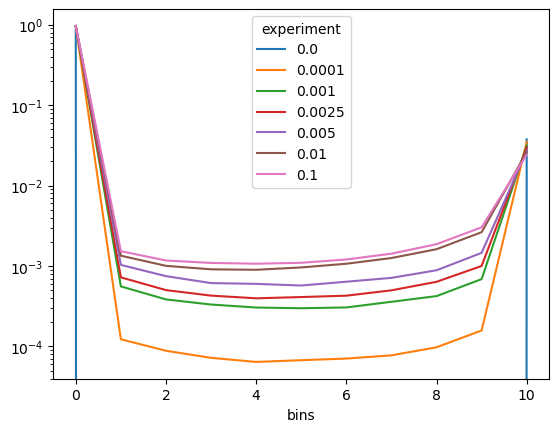

In [101]:
freq3_extreme.pr.to_pandas().T.plot()
plt.yscale('log')

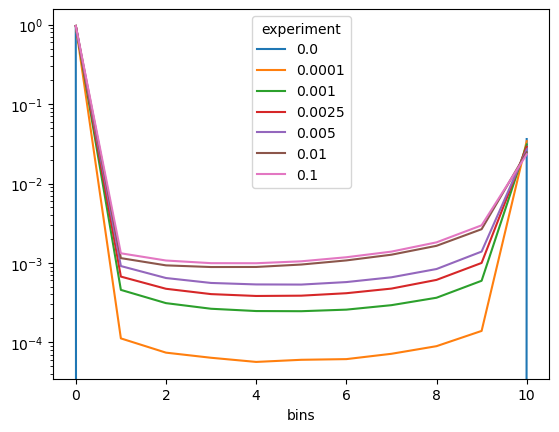

In [72]:
freq3_extreme.pr.to_pandas().T.plot()
plt.yscale('log')

In [ ]:
counts4_extreme.to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment2_rank_extreme.nc')

In [ ]:
counts3_extreme.to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment1_rank_extreme.nc')

In [12]:
freq = counts/counts.sum("bins")

In [13]:
freq2 = counts2/counts2.sum("bins")

In [14]:
freq3 = counts3/counts3.sum("bins")

In [15]:
freq4 = counts4/counts4.sum("bins")

In [3]:
counts3 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment1_rank.nc')

In [4]:
counts4= xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment2_rank.nc')

In [5]:
counts= xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment5_rank.nc')

In [6]:
counts2= xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment3_rank.nc')

In [128]:
counts3

<xarray.Dataset>
Dimensions:     (experiment: 7, bins: 11)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
Dimensions without coordinates: bins
Data variables:
    pr          (experiment, bins) int64 24165929 0 0 ... 4720469 16263749

In [7]:
blues =['#ADD8E6','#4682B4', '#00008B']
oranges = ['#FFA07A','#FF8C00','#FF4500']
markers =['D', '>', 'H']

In [8]:
v2_colors_o = ['tab:orange','#FF4500']
v2_colors_b = ['tab:blue','#00008B']

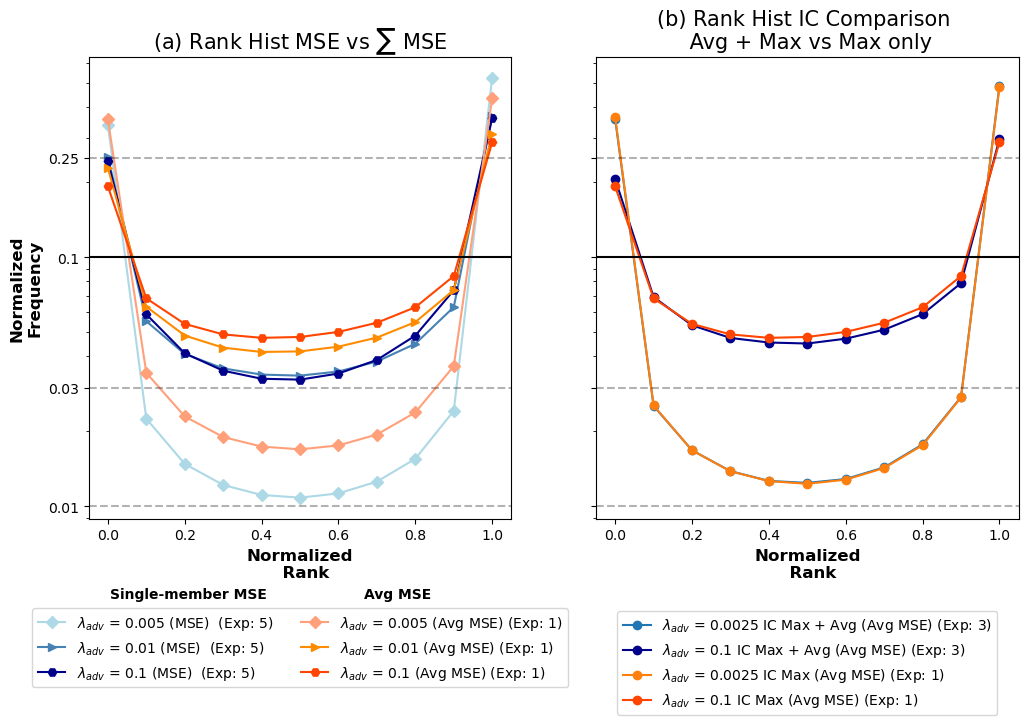

In [145]:
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex=True, sharey =True)
for i, lam in enumerate([0.0025, 0.1]):
    freq2.pr.sel(experiment =lam).plot(ax = ax[1], color=v2_colors_b[i] , marker ='o',
                                    label = r"$\lambda_{adv}$" + f" = {lam} IC Max + Avg (Avg MSE) (Exp: 3)")
for i, lam in enumerate([0.0025, 0.1]):
    freq3.pr.sel(experiment =lam).plot(ax = ax[1], color=v2_colors_o[i] , marker ='o',
                                    label = r"$\lambda_{adv}$" + f" = {lam} IC Max (Avg MSE) (Exp: 1)")
for i, lam in enumerate([0.005,0.01, 0.1]):
    freq.pr.sel(experiment =lam).plot(ax = ax[0], color =blues[i], marker = markers[i], label = r"$\lambda_{adv}$" + f" = {lam} (MSE)  (Exp: 5)")
    
for i, lam in enumerate([0.005,0.01, 0.1]):
    freq3.pr.sel(experiment =lam).plot(ax = ax[0], color =oranges[i], marker = markers[i], label = r"$\lambda_{adv}$" + f" = {lam} (Avg MSE) (Exp: 1)")
ax[0].set_yscale('log')
ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0].axhline(0.1, color ='k', ls ='-')
ax[0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[1].axhline(0.1, color ='k', ls ='-')
ax[1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0].set_yticks([0.01, 0.03, 0.1, 0.25])
ax[0].set_yticklabels([0.01, 0.03, 0.1, 0.25])
ax[0].set_ylabel('Normalized\nFrequency', fontsize =12, weight ='bold')
ax[0].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_title('(a) Rank Hist MSE vs $\sum$ MSE', fontsize =15)
ax[1].set_title('(b) Rank Hist IC Comparison \n Avg + Max vs Max only', fontsize =15)
ax[1].legend(ncol =1, loc = 'lower center', bbox_to_anchor = (0.5, -0.44))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_xticks(np.arange(0,12,2))
ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1].set_xticks(np.arange(0,12,2))
ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
ax[0].text(0.06, 0.0043, 'Single-member MSE', weight ='bold')
ax[0].text(6.66, 0.0043, 'Avg MSE', weight ='bold')
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/content_loss_comparison_Nor.png', dpi =700, bbox_inches ='tight')

In [9]:
cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]


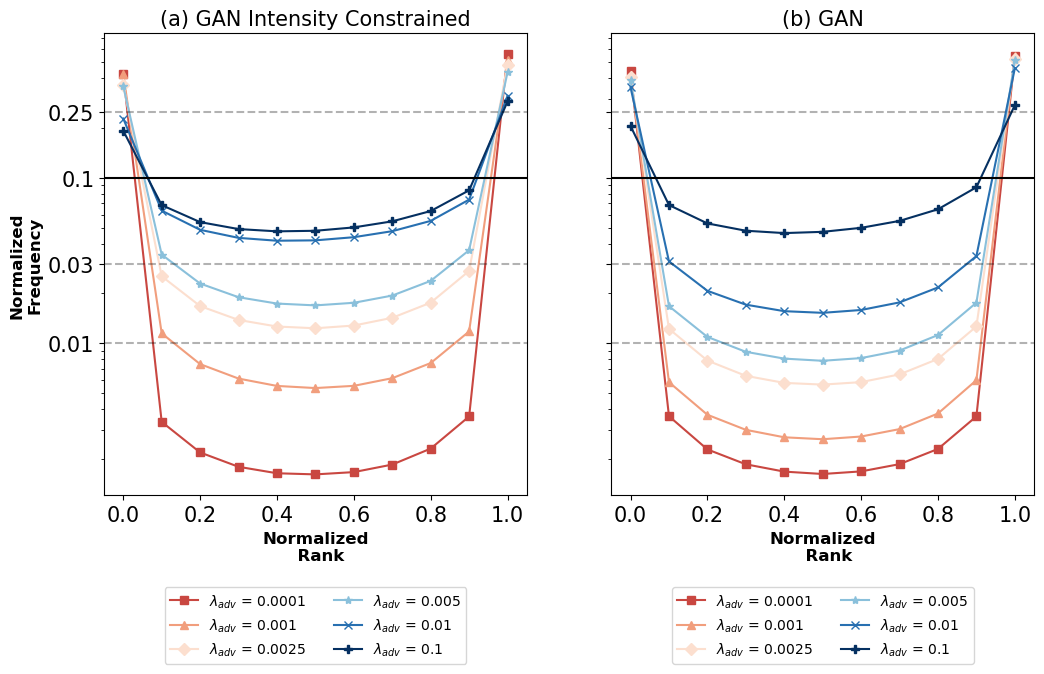

In [148]:
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex=True, sharey =True)
for i, lam in enumerate(freq3.experiment.values[1:]):
    freq3.pr.sel(experiment =lam).plot(ax = ax[0], color=colors_hist[i+1] , marker =marker_types[i+1],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")

for i, lam in enumerate(freq4.experiment.values[1:]):
    freq4.pr.sel(experiment =lam).plot(ax = ax[1], color =colors_hist[i+1], marker = marker_types[i+1], label = r"$\lambda_{adv}$" + f" = {lam}")
ax[0].set_yscale('log')
ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0].axhline(0.1, color ='k', ls ='-')
ax[0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[1].axhline(0.1, color ='k', ls ='-')
ax[1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0].set_yticks([0.01, 0.03, 0.1, 0.25])
ax[0].set_yticklabels([0.01, 0.03, 0.1, 0.25])
ax[0].set_ylabel('Normalized\nFrequency', fontsize =12, weight ='bold')
ax[0].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_title('(a) GAN Intensity Constrained', fontsize =15)
ax[1].set_title('(b) GAN', fontsize =15)
ax[1].legend(ncol =2, loc = 'lower center', bbox_to_anchor =(0.5, -0.38))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_xticks(np.arange(0,12,2))
ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1].set_xticks(np.arange(0,12,2))
ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/IC_vs_no_ic_Main_Arch.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/IC_vs_no_ic_Main_Arch.pdf', dpi =700, bbox_inches ='tight')

In [75]:
ranked =xs.rank_histogram(ground_truth.isel(time = slice(0,314)).pr.transpose("time", "lat","lon")*86400, 
                          df_bn_ic.isel(time = slice(0,314)).isel(experiment =-1).pr.transpose("time","lat","lon", "member")+1e-3)

In [77]:
ranked

<xarray.DataArray 'histogram_rank' (rank: 11)>
array([1681892,  618712,  559630,  552456,  570102,  601899,  651537,
        710458,  793676,  960890, 1966180])
Coordinates:
  * rank     (rank) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0

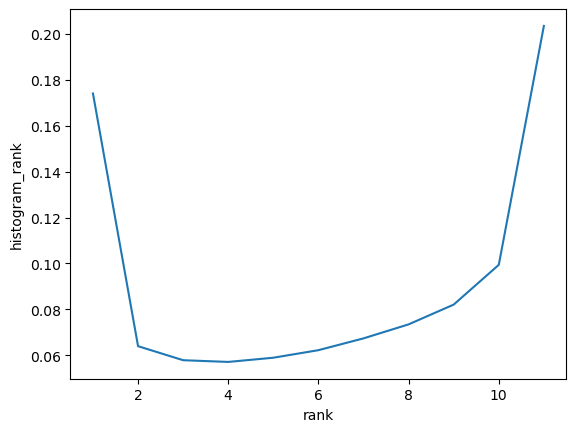

In [72]:
(ranked/ranked.sum()).plot()

In [97]:
counts5 = get_rank_hist(df_nobn, ground_truth)


In [95]:
counts6 = get_rank_hist(df_bn_ic, ground_truth)

In [96]:
counts7 = get_rank_hist(df_leaky, ground_truth)

In [16]:
counts6 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment6_rank1.nc')
counts7= xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment7_rank1.nc')
counts5= xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment8_rank1.nc')

In [17]:
freq5 = counts5/counts5.sum("bins")
freq6 = counts6/counts6.sum("bins")
freq7 = counts7/counts7.sum("bins")

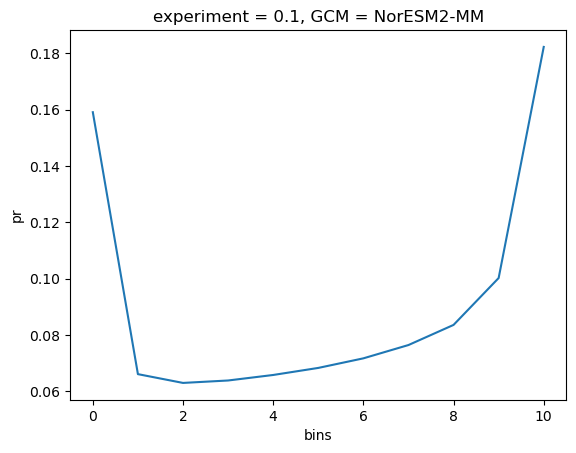

In [94]:
freq7.isel(experiment =-1).pr.plot()

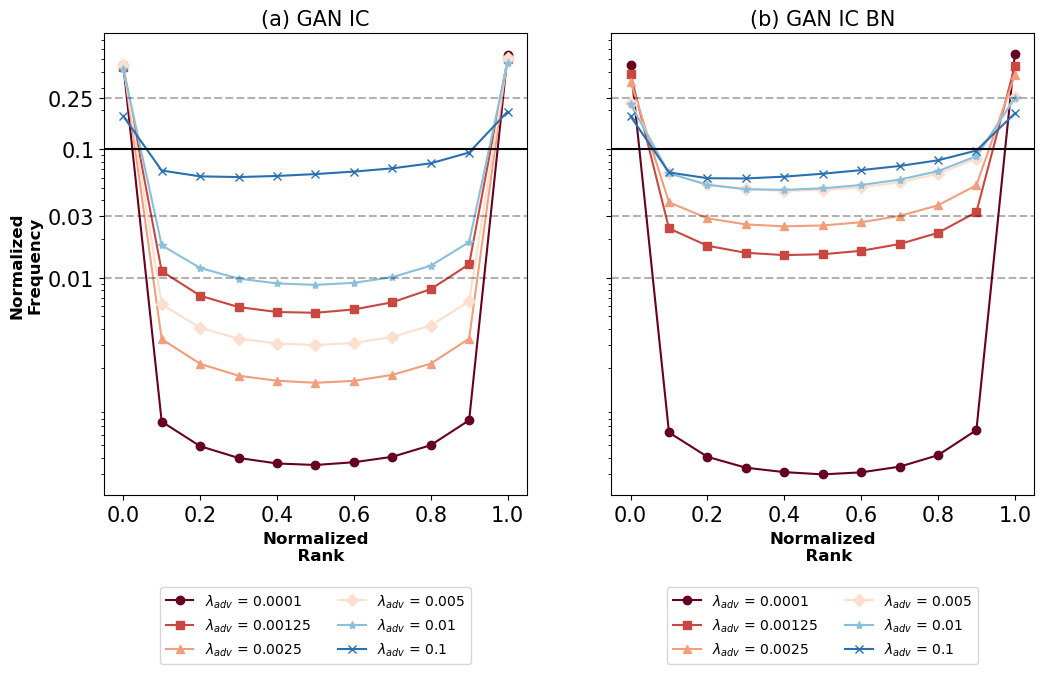

In [106]:
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex=True, sharey =True)
for i, lam in enumerate(freq5.experiment.values[1:]):
    freq5.pr.sel(experiment =lam).plot(ax = ax[0], color=colors_hist[i] , marker =marker_types[i],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")

for i, lam in enumerate(freq6.experiment.values[1:]):
    freq6.pr.sel(experiment =lam).plot(ax = ax[1], color =colors_hist[i], marker = marker_types[i], label = r"$\lambda_{adv}$" + f" = {lam}")
ax[0].set_yscale('log')
ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0].axhline(0.1, color ='k', ls ='-')
ax[0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[1].axhline(0.1, color ='k', ls ='-')
ax[1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0].set_yticks([0.01, 0.03, 0.1, 0.25])
ax[0].set_yticklabels([0.01, 0.03, 0.1, 0.25])
ax[0].set_ylabel('Normalized\nFrequency', fontsize =12, weight ='bold')
ax[0].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_title('(a) GAN IC', fontsize =15)
ax[1].set_title('(b) GAN IC BN', fontsize =15)
ax[1].legend(ncol =2, loc = 'lower center', bbox_to_anchor =(0.5, -0.38))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_xticks(np.arange(0,12,2))
ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1].set_xticks(np.arange(0,12,2))
ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
#ax[0].set_xticks(np.arange(0,12,2))
#ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
#ax[1].set_xticks(np.arange(0,12,2))
#ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/bn_vs_no_bn_comparison.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/bn_vs_no_bn_comparison.pdf', dpi =700, bbox_inches ='tight')

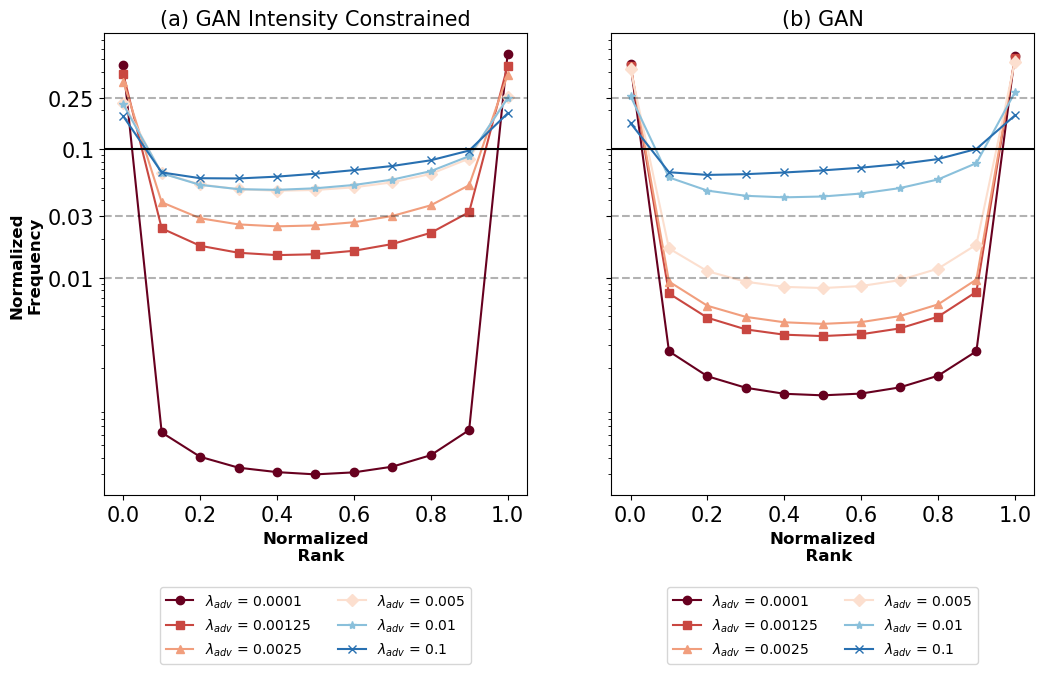

In [105]:
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex=True, sharey =True)
for i, lam in enumerate(freq5.experiment.values[1:]):
    freq6.pr.sel(experiment =lam).plot(ax = ax[0], color=colors_hist[i] , marker =marker_types[i],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")

for i, lam in enumerate(freq6.experiment.values[1:]):
    freq7.pr.sel(experiment =lam).plot(ax = ax[1], color =colors_hist[i], marker = marker_types[i], label = r"$\lambda_{adv}$" + f" = {lam}")
ax[0].set_yscale('log')
ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0].axhline(0.1, color ='k', ls ='-')
ax[0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[1].axhline(0.1, color ='k', ls ='-')
ax[1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0].set_yticks([0.01, 0.03, 0.1, 0.25])
ax[0].set_yticklabels([0.01, 0.03, 0.1, 0.25])
ax[0].set_ylabel('Normalized\nFrequency', fontsize =12, weight ='bold')
ax[0].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_title('(a) GAN Intensity Constrained', fontsize =15)
ax[1].set_title('(b) GAN', fontsize =15)
ax[1].legend(ncol =2, loc = 'lower center', bbox_to_anchor =(0.5, -0.38))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_xticks(np.arange(0,12,2))
ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1].set_xticks(np.arange(0,12,2))
ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/ic_vs_no_ic_arch_2.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/ic_vs_no_ic_arch_2.pdf', dpi =700, bbox_inches ='tight')

In [23]:
counts4 = xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Exp1_5/Experiment1_rank.nc')
freq4 = counts4.pr/counts4.pr.sum("bins")
                    

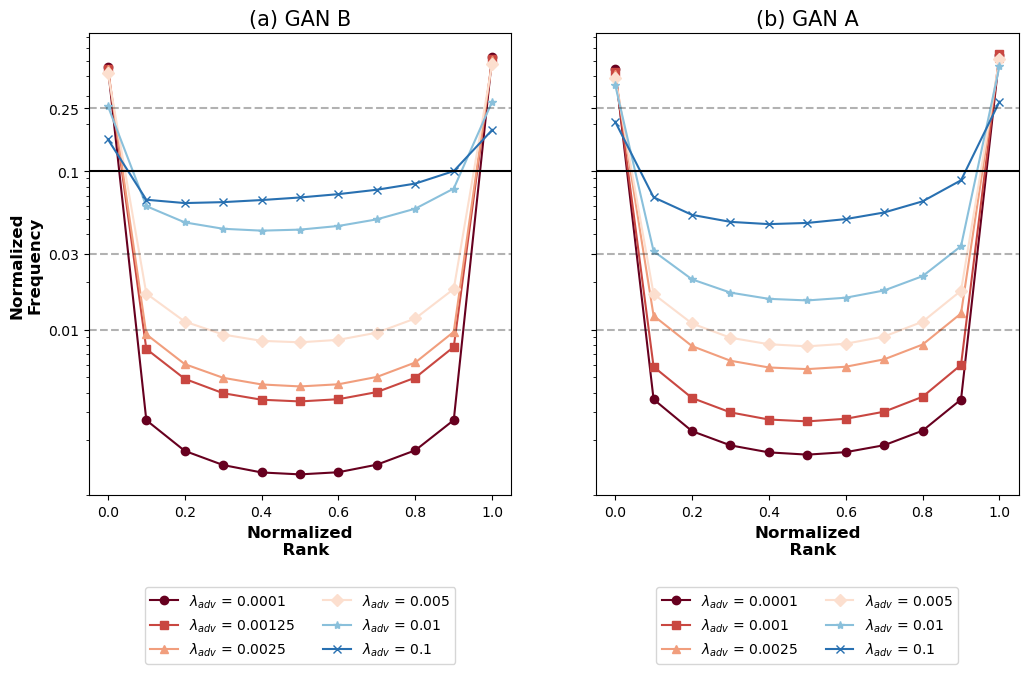

In [152]:
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex=True, sharey =True)
for i, lam in enumerate(freq5.experiment.values[1:]):
    freq7.pr.sel(experiment =lam).plot(ax = ax[0], color=colors_hist[i] , marker =marker_types[i],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")

for i, lam in enumerate(freq4.experiment.values[1:]):
    freq4.pr.sel(experiment =lam).plot(ax = ax[1], color =colors_hist[i], marker = marker_types[i], label = r"$\lambda_{adv}$" + f" = {lam}")
ax[0].set_yscale('log')
ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0].axhline(0.1, color ='k', ls ='-')
ax[0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[1].axhline(0.1, color ='k', ls ='-')
ax[1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0].set_yticks([0.01, 0.03, 0.1, 0.25])
ax[0].set_yticklabels([0.01, 0.03, 0.1, 0.25])
ax[0].set_ylabel('Normalized\nFrequency', fontsize =12, weight ='bold')
ax[0].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_title('(a) GAN B', fontsize =15)
ax[1].set_title('(b) GAN A', fontsize =15)
ax[1].legend(ncol =2, loc = 'lower center', bbox_to_anchor =(0.5, -0.38))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_xticks(np.arange(0,12,2))
ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1].set_xticks(np.arange(0,12,2))
ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/No_ic_arch_comp.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/No_ic_arch_comp.pdf', dpi =700, bbox_inches ='tight')

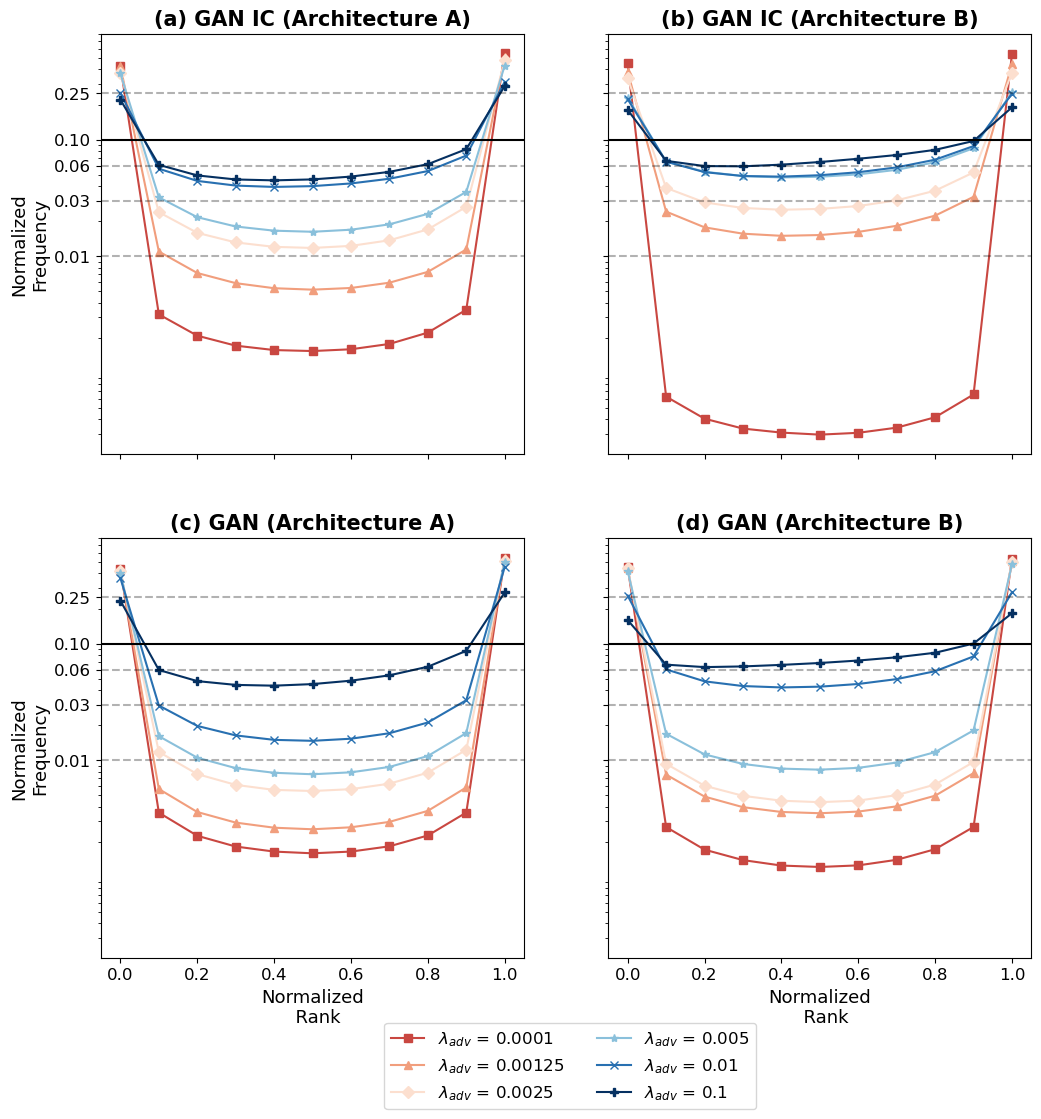

In [48]:
fig, ax = plt.subplots(2,2, figsize = (12, 12), sharex=True, sharey =True)

for i, lam in enumerate(freq3.experiment.values[1:]):
    freq3.pr.sel(experiment =lam).plot(ax = ax[0,0], color=colors_hist[i+1] , marker =marker_types[i+1],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")
for i, lam in enumerate(freq6.experiment.values[1:]):
    freq6.pr.sel(experiment =lam).plot(ax = ax[0,1], color=colors_hist[i+1] , marker =marker_types[i+1],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")
    
for i, lam in enumerate(freq4.experiment.values[1:]):
    freq4.pr.sel(experiment =lam).plot(ax = ax[1,0], color=colors_hist[i+1] , marker =marker_types[i+1],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")
for i, lam in enumerate(freq7.experiment.values[1:]):
    freq7.pr.sel(experiment =lam).plot(ax = ax[1,1], color=colors_hist[i+1] , marker =marker_types[i+1],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")


ax[0,0].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0,0].axhline(0.1, color ='k', ls ='-')
ax[0,0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0,0].axhline(0.06, color ='k', ls ='--', alpha =0.3)
ax[0,0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0,0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0,1].axhline(0.1, color ='k', ls ='-')
ax[0,1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0,1].axhline(0.06, color ='k', ls ='--', alpha =0.3)
ax[0,1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0,1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1,1].axhline(0.1, color ='k', ls ='-')
ax[1,1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1,1].axhline(0.06, color ='k', ls ='--', alpha =0.3)
ax[1,1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1,1].axhline(0.01, color ='k', ls ='--', alpha =0.3)
ax[1,0].axhline(0.1, color ='k', ls ='-')
ax[1,0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1,0].axhline(0.06, color ='k', ls ='--', alpha =0.3)
ax[1,0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1,0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1,0].set_yscale('log')

#ax[0].grid('on')
ax[0,0].set_yticks([0.01, 0.03,0.06, 0.10, 0.25])
ax[0,0].set_yticklabels(["%.2f" % f for f in [0.01, 0.03,0.06, 0.10, 0.25]])

ax[1,0].set_yticks([0.01, 0.03,0.06, 0.10, 0.25])
ax[1,0].set_yticklabels(["%.2f" % f for f in [0.01, 0.03,0.06, 0.10, 0.25]])

ax[0,0].set_ylabel('Normalized\nFrequency', fontsize =13)
ax[1,0].set_ylabel('Normalized\nFrequency', fontsize =13)
ax[1,0].set_xlabel('Normalized\n  Rank', fontsize =13)
ax[1,1].set_xlabel('Normalized\n  Rank', fontsize =13)
ax[0,0].tick_params(labelsize =12)
ax[0,1].tick_params(labelsize =12)
ax[1,0].tick_params(labelsize =12)
ax[1,1].tick_params(labelsize =12)

ax[0,0].set_title('(a) GAN IC (Architecture A)', fontsize =15, weight ='bold')
ax[0,1].set_title('(b) GAN IC (Architecture B)', fontsize =15, weight ='bold')
ax[1,0].set_title('(c) GAN (Architecture A)', fontsize =15, weight ='bold')
ax[1,1].set_title('(d) GAN (Architecture B)', fontsize =15, weight ='bold')
#ax[1].set_title('(b) GAN IC (A)', fontsize =15)
#ax[1].legend(ncol =2, loc = 'lower center', bbox_to_anchor =(0.5, -0.38))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[0,1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1,1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[0,1].set_xlabel(' ', fontsize =12, weight ='bold')
ax[0,0].set_xlabel(' ', fontsize =12, weight ='bold')
#ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[1,0].set_xticks(np.arange(0,12,2))
ax[1,0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1,1].set_xticks(np.arange(0,12,2))
ax[1,1].set_xticklabels(np.arange(0,12,2)/10.0)


ax[1,1].legend(ncol =2, loc = 'lower left', bbox_to_anchor = (-0.55, -0.38), fontsize =12, fancybox =True)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Final_Figure_final.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/Final_Figure_final.pdf', dpi =700, bbox_inches ='tight')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex=True, sharey =True)
for i, lam in enumerate(freq3.experiment.values[1:]):
    freq3.pr.sel(experiment =lam).plot(ax = ax[0], color=colors_hist[i+1] , marker =marker_types[i+1],
                                    label = r"$\lambda_{adv}$" + f" = {lam}")

for i, lam in enumerate(freq4.experiment.values[1:]):
    freq4.pr.sel(experiment =lam).plot(ax = ax[1], color =colors_hist[i+1], marker = marker_types[i+1], label = r"$\lambda_{adv}$" + f" = {lam}")
ax[0].set_yscale('log')
ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[0].axhline(0.1, color ='k', ls ='-')
ax[0].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[0].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[1].set_yscale('log')
#ax[0].legend(ncol =2, loc = 'lower center', bbox_to_anchor = (0.5, -0.38))
#ax[0].grid('on')
ax[1].axhline(0.1, color ='k', ls ='-')
ax[1].axhline(0.03, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.25, color ='k', ls ='--', alpha =0.3)
ax[1].axhline(0.01, color ='k', ls ='--', alpha =0.3)

ax[0].set_yticks([0.01, 0.03, 0.1, 0.25])
ax[0].set_yticklabels([0.01, 0.03, 0.1, 0.25])
ax[0].set_ylabel('Normalized\nFrequency', fontsize =12, weight ='bold')
ax[0].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_title('(a) GAN Intensity Constrained', fontsize =15)
ax[1].set_title('(b) GAN', fontsize =15)
ax[1].legend(ncol =2, loc = 'lower center', bbox_to_anchor =(0.5, -0.38))
#ax[0].text(-2.25, 0.047, '5 x $10^{-2}$')
ax[1].set_ylabel(' ', fontsize =12, weight ='bold')
ax[1].set_xlabel('Normalized\n  Rank', fontsize =12, weight ='bold')
ax[0].set_xticks(np.arange(0,12,2))
ax[0].set_xticklabels(np.arange(0,12,2)/10.0)
ax[1].set_xticks(np.arange(0,12,2))
ax[1].set_xticklabels(np.arange(0,12,2)/10.0)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
#ax[0].text(-2.55, 0.24, '2.5 x $10^{-1}$')
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/IC_vs_no_ic_Main_Arch.png', dpi =700, bbox_inches ='tight')
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_histogram/IC_vs_no_ic_Main_Arch.pdf', dpi =700, bbox_inches ='tight')

In [77]:
import matplotlib.colors as mcolors
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)

In [ ]:

fig, ax = plt.subplots(3,3, figsize = (9, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
pressure_field_hpa = pressure_fields.sel(time =time).psl/ 100
#ax = ax.T
lambdas = [0,4, -1]
levels = np.arange(0,7, 0.2)
for j in range(3):
    
    ens_mean = dsets.sel(time =time).isel(experiment =lambdas[j]).mean("member")
    for i in range(3):

        pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   lon = slice(167, 180)).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = dsets.sel(time =time).isel(member =i, experiment =lambdas[j]).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], 
                                                                                            add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        # contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
        # contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')

                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            ax[i,j].set_title('$\lambda_{adv}$ =' + str(dsets.experiment.values[lambdas[j]]), fontsize =22)
        if j ==0:
            ax[i,j].text(148, -43, f'Member = {i}', weight ='bold', transform = ccrs.PlateCarree(), fontsize =15)
        if (i ==0) & (j ==0):
            ax[i,j].set_title('Regression \nBaseline \n($\lambda_{adv}$ =' + str(dsets.experiment.values[lambdas[j]]) +")", fontsize =22)
        

#ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



#cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 18, weight ='bold')
fig.tight_layout()
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.png', dpi =500, bbox_inches ='tight')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.pdf', dpi =500, bbox_inches ='tight')
        #ax[i,j]